Code originated from https://github.com/goru001/nlp-for-hindi/blob/master/language-model/Hindi_Language_Model.ipynb

Modifications for tamil:

Parse wikidump instead of crawling (mostly because I did not take time to adapt the crawler and also because thought it would be efficient to get whole thing in one go).

Used close to 60000 articles (200 of the large wikiextract resulting docs)

Tried 8000 word and 16000 word vocabulary for Sentence Piece.

Perplexity of 37.

Updated the text generator section with a slightly better probing function.


## Section 1. Wiki article extractor from Tamil Wiki Dump

In [2]:
from urllib.request import urlopen
import pickle

In [3]:
!wget http://dumps.wikimedia.org/tawiki/latest/tawiki-latest-pages-articles.xml.bz2

--2019-03-19 02:20:43--  http://dumps.wikimedia.org/tawiki/latest/tawiki-latest-pages-articles.xml.bz2
Resolving dumps.wikimedia.org (dumps.wikimedia.org)... 208.80.155.106, 2620:0:861:4:208:80:155:106
Connecting to dumps.wikimedia.org (dumps.wikimedia.org)|208.80.155.106|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://dumps.wikimedia.org/tawiki/latest/tawiki-latest-pages-articles.xml.bz2 [following]
--2019-03-19 02:20:44--  https://dumps.wikimedia.org/tawiki/latest/tawiki-latest-pages-articles.xml.bz2
Connecting to dumps.wikimedia.org (dumps.wikimedia.org)|208.80.155.106|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 141129076 (135M) [application/octet-stream]
Saving to: ‘tawiki-latest-pages-articles.xml.bz2’

tawiki-latest-pages 100%[===================>] 134.59M  1.95MB/s    in 69s     

2019-03-19 02:21:53 (1.96 MB/s) - ‘tawiki-latest-pages-articles.xml.bz2’ saved [141129076/141129076]



In [4]:
!bunzip2 tawiki-latest-pages-articles.xml.bz2

In [5]:
!ls -ltr

total 1163700
-rw-r--r-- 1 ravi_annaswamy ravi_annaswamy 1190436342 Mar  2 07:30 tawiki-latest-pages-articles.xml
-rw-r--r-- 1 ravi_annaswamy ravi_annaswamy    1183927 Mar 19 02:21 tamil_nlp_wikilink_article_tokenizer_lm.ipynb


In [6]:
!git clone https://github.com/attardi/wikiextractor.git

Cloning into 'wikiextractor'...
remote: Enumerating objects: 523, done.
remote: Total 523 (delta 0), reused 0 (delta 0), pack-reused 523
Receiving objects: 100% (523/523), 454.22 KiB | 0 bytes/s, done.
Resolving deltas: 100% (297/297), done.


In [7]:
import os
%cd wikiextractor

/home/ravi_annaswamy/tamil_lm/wikiextractor


In [8]:
!ls

ChangeLog	   extractPage.py  README.md  tests.py	WikiExtractor.py
cirrus-extract.py  LICENSE	   setup.py   tox.ini


In [9]:
!python WikiExtractor.py ../tawiki-latest-pages-articles.xml --no-templates -q

WikiExtractor.py:2432: DeprecationWarning: Flags not at the start of the expression '\\[(((?i)bitcoin:|ftp' (truncated)
  re.S | re.U)
WikiExtractor.py:2439: DeprecationWarning: Flags not at the start of the expression '^(http://|https://)(' (truncated)
  re.X | re.S | re.U)


In [10]:
!ls

ChangeLog	   extractPage.py  README.md  tests.py	tox.ini
cirrus-extract.py  LICENSE	   setup.py   text	WikiExtractor.py


In [2]:
import glob
flist=glob.glob('text/*/*')

In [3]:
len(flist)

444

In [13]:
def future_name(fn):
  a,b,c=fn.split('/')
  return '/'.join([a,b,b+'_'+c+'.txt'])
future_name(flist[0])

'text/AE/AE_wiki_12.txt'

In [14]:
import os
for f in flist:
  os.rename(f,future_name(f))

In [14]:
flist=glob.glob('text/*/*')
len(flist),flist[:2]

(444, ['text/AE/AE_wiki_34.txt', 'text/AE/AE_wiki_04.txt'])

## Section 2: Create a Tamil Tokenizer using Google SentencePiece

In [18]:
!pip install sentencepiece --user

  Using cached https://files.pythonhosted.org/packages/bf/7b/ccbfae16c95700646e9093fbed2f0a551e4fadc6355c3595c88b53644220/sentencepiece-0.1.8-cp37-cp37m-manylinux1_x86_64.whl


In [1]:
import sentencepiece as spm
import random

In [11]:
fname=random.choice(flist)
with open(fname, encoding='utf-8') as f:
    text = f.read()
text

'<doc id="366544" url="https://ta.wikipedia.org/wiki?curid=366544" title="ஆர்த்தி ராமசாமி">\nஆர்த்தி ராமசாமி\n\nஆர்த்தி ராமசாமி ("Aarthie Ramaswamy") என்பவர் ஓர் இந்திய பெண் சதுரங்க விளையாட்டு வீரராவார். பெண் கிராண்டு மாசுட்டர் என்ற பெருமையும் இவருக்கு உண்டு. 1981 ஆம் ஆண்டு சூன் 28 ஆம் தேதி இவர் பிறந்தார். 2003 ஆம் ஆண்டில் தேசிய சதுரங்க சாம்பியன் பட்டத்தை ஆர்த்தி வென்றார். 1999 ஆம் ஆண்டு எசுப்பானியாவின் ஓரோபெசா நகரத்தில் நடைபெற்ற 18 வயதிற்கு உட்பட்டோருக்கான பெண்கள் உலக சதுரங்க சாம்பியன் பட்டப்போட்டியிலும் வெற்றி பெற்றுள்ளார். தற்போது 2211 எலோ தரப்புள்ளிகள் பெற்ற சதுரங்க வீரராக உள்ளார். \n\n1990 ஆம் ஆண்டு இந்திய அளவில் நடைபெற்ற பத்து வயதிற்குட்பட்டவர்களுக்கான பெண்கள் சதுரங்க விளையாட்டில் இரண்டாம் இடம் பிடித்தார். 1993 ஆம் ஆண்டு 12 வயதிற்குபட்டவர்களுக்கான விளையாட்டுப் பிரிவில் முதலிடத்தைப் பிடித்தார். தனது அடுத்தடுத்த அதிரடியான நகர்வுகள் மூலம் 1995 ஆம் ஆண்டில் 14 வயதுக்கு உட்பட்டோர் , 16 வயதிற்கு உட்பட்டோர் சாம்பியன் பட்டங்களை வென்றார். 1998, 1999 ஆம் ஆண்டுகளில் 18 வயதுக்கு உட்பட்டோருக்க

In [15]:
flist=','.join(flist[:200])
flist[:45]

'text/AE/AE_wiki_34.txt,text/AE/AE_wiki_04.txt'

In [16]:
spm.SentencePieceTrainer.Train(f'--input={flist} --model_prefix=tamil_lm_8k --vocab_size=16000')

True

In [17]:
sp = spm.SentencePieceProcessor()

In [18]:
sp.Load("tamil_lm_8k.model")

True

In [19]:
sp.EncodeAsPieces(text)

['▁<',
 'doc',
 '▁id',
 '="',
 '36',
 '65',
 '44"',
 '▁',
 'url',
 '="',
 'http',
 's',
 '://',
 'ta',
 '.',
 'wiki',
 'pedia',
 '.',
 'org',
 '/',
 'wiki',
 '?',
 'curi',
 'd',
 '=',
 '36',
 '65',
 '44"',
 '▁title',
 '="',
 'ஆர்',
 'த்தி',
 '▁ராமசாமி',
 '">',
 '▁ஆர்',
 'த்தி',
 '▁ராமசாமி',
 '▁ஆர்',
 'த்தி',
 '▁ராமசாமி',
 '▁("',
 'A',
 'ar',
 'th',
 'ie',
 '▁Ra',
 'ma',
 's',
 'wa',
 'my',
 '")',
 '▁என்பவர்',
 '▁ஓர்',
 '▁இந்திய',
 '▁பெண்',
 '▁சதுரங்க',
 '▁விளையாட்டு',
 '▁வீர',
 'ராவார்',
 '.',
 '▁பெண்',
 '▁கிராண்டு',
 '▁மாசுட்டர்',
 '▁என்ற',
 '▁பெருமை',
 'யும்',
 '▁இவருக்கு',
 '▁உண்டு',
 '.',
 '▁1981',
 '▁ஆம்',
 '▁ஆண்டு',
 '▁சூன்',
 '▁28',
 '▁ஆம்',
 '▁தேதி',
 '▁இவர்',
 '▁பிறந்தார்',
 '.',
 '▁2003',
 '▁ஆம்',
 '▁ஆண்டில்',
 '▁தேசிய',
 '▁சதுரங்க',
 '▁சாம்பியன்',
 '▁பட்டத்தை',
 '▁ஆர்',
 'த்தி',
 '▁வென்றார்',
 '.',
 '▁1999',
 '▁ஆம்',
 '▁ஆண்டு',
 '▁எசுப்பானியாவ',
 'ின்',
 '▁ஓ',
 'ரோ',
 'பெ',
 'சா',
 '▁நகரத்தில்',
 '▁நடைபெற்ற',
 '▁18',
 '▁வயதிற்கு',
 '▁உட்பட்ட',
 'ோருக்கான',
 '▁பெண்கள்',
 '▁உல

In [20]:
!head -50 tamil_lm_8k.vocab

<unk>	0
<s>	0
</s>	0
.	-3.01199
,	-3.67553
▁	-4.30789
="	-4.91583
க்	-4.92705
ப்	-4.94152
ம்	-4.95616
்	-4.99678
▁மற்றும்	-5.15703
கள்	-5.16299
)	-5.17732
wiki	-5.1859
doc	-5.19544
▁(	-5.24171
த்	-5.32342
▁ஒரு	-5.39281
"	-5.55251
s	-5.55413
▁"	-5.58825
d	-5.70313
/	-5.71329
>	-5.79667
ta	-5.8381
?	-5.84268
▁<	-5.84976
://	-5.87334
http	-5.87374
org	-5.87479
pedia	-5.88396
▁</	-5.88456
curi	-5.88856
url	-5.8887
▁title	-5.8891
▁id	-5.88934
ு	-5.89728
">	-5.89798
ச்	-5.90737
-	-5.95312
ல்	-5.96339
▁இந்த	-5.9927
து	-6.03501
ும்	-6.05012
ஸ்	-6.07981
▁இது	-6.14298
▁ஆம்	-6.15271
ன்	-6.18755
ின்	-6.19383


## Section 3. Build Language Model from Wiki-ta using fastai and SPM


In [21]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [65]:
!pip install fastai --upgrade --user

    100% |████████████████████████████████| 215kB 14.3MB/s ta 0:00:01


In [22]:
from fastai.text import *
import numpy as np
from sklearn.model_selection import train_test_split
import pickle
import sentencepiece as spm

In [23]:
import fastai, torch
fastai.__version__ , torch.__version__

('1.0.50.post1', '1.0.0')

In [24]:
torch.cuda.set_device(0)

In [25]:
!ls

ChangeLog	    tamil_lm_16k.vocab
cirrus-extract.py   tamil_lm_8k.model
extractPage.py	    tamil_lm_8k.vocab
LICENSE		    tamil_lm.model
README.md	    tamil_lm.vocab
setup.py	    tamil_nlp_wikilink_article_tokenizer_lm_10k_50f.ipynb
TamilDataset200     tamil_nlp_wikilink_article_tokenizer_lm_12k_50f.ipynb
TamilDataset50	    tamil_nlp_wikilink_article_tokenizer_lm_12k.ipynb
TamilDatasetFull    tamil_nlp_wikilink_article_tokenizer_lm.ipynb
tamil_lm_10k.model  tests.py
tamil_lm_10k.vocab  text
tamil_lm_12k.model  tox.ini
tamil_lm_12k.vocab  WikiExtractor.py
tamil_lm_16k.model


In [26]:
path = Path('.')

In [27]:
p = path.glob('text/*/*')
files = [str(x) for x in p if x.is_file()]
len(files)

444

In [101]:
train_files, test_files = train_test_split(files[:200], test_size=0.2)

In [102]:
len(train_files), len(test_files)

(160, 40)

In [103]:
!mkdir TamilDataset200
!mkdir TamilDataset200/train
!mkdir TamilDataset200/valid

In [104]:
# Preparing dataset for fastai
for file in train_files:
    with open(file, encoding='utf-8') as f:
        text = f.read()
    with open(path/'TamilDataset200'/'train'/(str(file).split('/')[-1]+'.txt'), "w") as text_file:
        text_file.write(text)

In [105]:
#!ls -ltr TamilDataset/train/

In [106]:
for file in test_files:
    with open(file, encoding='utf-8') as f:
        text = f.read()
    with open(path/'TamilDataset200'/'valid'/(str(file).split('/')[-1]+'.txt'), "w") as text_file:
        text_file.write(text)

In [70]:
class TamilTokenizer(BaseTokenizer):
    def __init__(self, lang:str):
        self.lang = lang
        self.sp = spm.SentencePieceProcessor()
        self.sp.Load(str(path/"tamil_lm_8k.model"))
        
    def tokenizer(self, t:str) -> List[str]:
        return self.sp.EncodeAsPieces(t)

In [71]:
sp = spm.SentencePieceProcessor()
sp.Load(str(path/"tamil_lm_8k.model"))
itos = [sp.IdToPiece(int(i)) for i in range(8000)]

In [30]:
#itos

In [72]:
tamil_vocab = Vocab(itos)

In [73]:
tokenizer = Tokenizer(tok_func=TamilTokenizer, lang='ta')

In [74]:
tokenizer.special_cases

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep']

In [75]:
data_lm = TextLMDataBunch.from_folder(path=path/'TamilDataset200', tokenizer=tokenizer, vocab=tamil_vocab)

In [76]:
data_lm.batch_size

64

In [77]:
data_lm.save()

In [78]:
data_lm.show_batch()

idx,text
0,"▁மிகப்பெரிய ▁நகர மும் ▁ஆகும் . ▁இது ▁தெற்கு ▁பின்லாந்த ின் ▁பால் டிக் ▁கடல ின் ▁பின்லாந்த ு ▁வளைகுடா வின் ▁கடற்கரை யில் ▁அமைந்துள்ளது . ▁இந்நகர த்தின் ▁ம க்கட்ட ொ கை ▁சுமார் ▁5 64 , 90 8 ▁ஆகும் ▁( 31 ▁ஜனவரி ▁2007 ▁இன் ▁படி ) . ▁ஏறத்தாழ ▁பின்லாந்த ில் ▁10 ல் ▁ஒருவர் ▁இந் ▁நகரத்தில் ▁வாழ்கின்றனர் . ▁ஹெ ல் சி ங்கி ▁மற்றும் ▁அருகில் ▁உள்ள ▁நகர் களான ▁ யெ ஸ் ப்பூ , ▁வன் டா ▁மற்றும்"
1,"▁2011 ▁சட்டமன்றத் ▁தேர்தலில் ▁போட்டியிட்டு ▁வெற்றி வாய் ப்பை ▁இழந்த ுள்ளார் . ▁மருத்துவர் ▁அருள் மணி ▁புது கோ ட்டை ▁மாவட்டம் , ▁கீ ர மங்கலம் ▁தா லு கா ▁சே ந்த ன் குடி யைச் ▁சேர்ந்தவர் . ▁தந்தை ▁சுப்பிரமணிய ன் ▁ஆசிரியர் . ▁மருத்துவ ப் ▁படிப்ப ில் ▁உயர் ▁கல்வி ▁பெற்று , ▁அற ந்தா ங்கி யில் ▁' அ ம் மன் ▁மரு த்த வ ▁ம னை ' ▁என்ற ▁பெயரில் ▁மருத்துவமனை ▁நடத்தி ▁வருகிறார் . ▁< ▁ / ▁ doc"
2,"▁பந்த ினை ▁கை க்கொள்ள ▁முயன்ற ப் போது , ▁இந்த ▁நிகழ்ச்சி ▁நடு வர் ▁ஹோ ரா சியோ ▁எலி சோ ண்டோ வின் ▁நேர் ▁முன்பாக ▁நிகழ்ந்த து . ▁ரூ னி யின் ▁யுனைடெட் ▁அணி ▁ச கா ▁கிறிஸ் டியா னோ ▁ரோ னால் டோ ▁வெளிப்படையாக ▁அவரது ▁செயல ைக் ▁எதிர் த்தார் , ▁ரூ னி ▁திரும்ப ▁அவரை ▁முன்ன ுக்கு த் ▁தள்ள ினார் . ▁எலி சோ ண்டோ ▁ரூ னி யை ▁வெளியே ▁அனுப்ப ினார் , ▁அதன் ▁பிறகு ▁ரோ னால் டோ"
3,"▁< doc ▁id ="" 12 56 33"" ▁ url ="" http s : ▁ / ▁ / ▁ ta . wiki pedia . org ▁ / ▁ wiki ? curi d = 12 56 33"" ▁title ="" லெ னர் ட் ▁பே ட்ஸ் ""> ▁லெ னர் ட் ▁பே ட்ஸ் ▁லெ னர் ட் ▁பே ட்ஸ் ▁("" l e on ard <unk> ▁b ate s "", ▁பிறப்பு : ▁மார்ச்சு ▁20 ▁18 95"
4,"▁c ▁= ▁2 <unk> ▁என் க . ▁இ க்கோ ணம் ▁இரு சம க் கூற ிட ப்படுவதால் : ▁ஒரு ▁முக்கோண த்தின் ▁மூன்று ▁கோண ங்களின் ▁கூடுதல் ▁18 0 ° ▁என்பதால் , ▁முக்கோண ம் <unk> <unk> c ▁- ன் ▁மூன்று ▁கோண ங்களின் ▁கூடுதல் : ▁முக்கோண ம் <unk> <unk> c ▁- ன் ▁கோண ங்கள் : ▁ 36 ° - 72 ° - 72 ° . ▁விரி கோண ▁இரு சம பக்க ▁முக்கோண ம் <unk>"


In [79]:
len(data_lm.vocab.itos)

8000

# Section 4. Train it

In [82]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

In [83]:
gc.collect()

1024

In [84]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


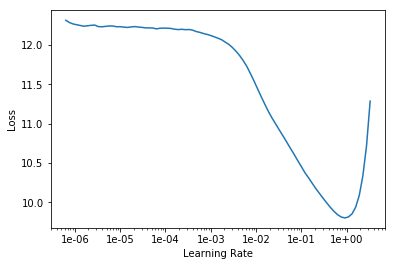

In [85]:
learn.recorder.plot()

In [86]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.976160,4.796425,0.238848,20:57


In [87]:
learn.save('first', with_opt=True)

In [88]:
learn.load('first', with_opt=True);

In [89]:
learn.unfreeze()

In [90]:
learn.fit_one_cycle(5, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.168198,4.422420,0.273664,26:14
1,4.158468,4.241174,0.291059,26:07
2,3.920514,4.004230,0.317659,26:00
3,3.697713,3.772478,0.344701,26:03
4,3.598254,3.704702,0.354343,26:07


In [91]:
learn.save('second_hi_lm', with_opt=True)

In [92]:
learn.load('second_hi_lm', with_opt=True);

In [93]:
!ls -ltr

total 10488
-rw-r--r-- 1 ravi_annaswamy ravi_annaswamy   35122 Mar 19 02:22 LICENSE
-rw-r--r-- 1 ravi_annaswamy ravi_annaswamy   18004 Mar 19 02:22 ChangeLog
-rwxr-xr-x 1 ravi_annaswamy ravi_annaswamy  116228 Mar 19 02:22 WikiExtractor.py
-rw-r--r-- 1 ravi_annaswamy ravi_annaswamy      74 Mar 19 02:22 tox.ini
-rw-r--r-- 1 ravi_annaswamy ravi_annaswamy    3316 Mar 19 02:22 tests.py
-rw-r--r-- 1 ravi_annaswamy ravi_annaswamy     476 Mar 19 02:22 setup.py
-rw-r--r-- 1 ravi_annaswamy ravi_annaswamy    5366 Mar 19 02:22 README.md
-rwxr-xr-x 1 ravi_annaswamy ravi_annaswamy    4438 Mar 19 02:22 extractPage.py
-rwxr-xr-x 1 ravi_annaswamy ravi_annaswamy    8340 Mar 19 02:22 cirrus-extract.py
drwxr-xr-x 7 ravi_annaswamy ravi_annaswamy    4096 Mar 19 02:24 text
-rw-r--r-- 1 ravi_annaswamy ravi_annaswamy 1145247 Mar 19 02:46 tamil_lm.model
-rw-r--r-- 1 ravi_annaswamy ravi_annaswamy  923743 Mar 19 02:46 tamil_lm.vocab
-rw-r--r-- 1 ravi_annaswamy ravi_annaswamy 1189763 Mar 19 10:36 tamil_nlp_wikilin

In [103]:
learn.fit_one_cycle(20, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.418257,3.703921,0.354770,26:03
1,3.385896,3.699066,0.355450,26:04
2,3.502406,3.692003,0.356158,26:06
3,3.437326,3.685202,0.357103,26:08
4,3.534894,3.679254,0.357922,26:08
5,3.405038,3.672608,0.358669,26:07
6,3.407530,3.666891,0.360012,26:07
7,3.465725,3.656222,0.361099,26:09
8,3.272799,3.650724,0.362004,26:12
9,3.349825,3.644597,0.362977,26:07


In [104]:
learn.save('third_hi_lm', with_opt=True)

In [105]:
learn.load('third_hi_lm', with_opt=True);

In [123]:
np.exp(3.623)

37.449748712720165

# Section 5. Probe the LM by asking it to complete phrases.



In [ ]:
text='இவருடைய கவிதைகள்'

N_WORDS = 60
N_SENTENCES = 5

In [122]:
def create(text, spm=False, N_WORDS=50):
    TEXT=sp.EncodeAsPieces(text)
    TEXT=' '.join(TEXT)
    sp_merge=lambda s:s.replace(' ','').replace('▁',' ')
    samples=[]
    for _ in range(N_SENTENCES):
      sample=learn.predict(TEXT, N_WORDS, temperature=0.7)
      samples.append(sample)
      if spm:
          print(sample)
          print()
    if spm:
        print()
    for sample in samples:
      sample=sp_merge(sample)
      print(sample)
      print()


 17-ஆம் நூற்றாண்டில் இப்பெயரை பயன்படுத்தினார்கள். < / doc> <doc id="121662" url="https: / / ta.wikipedia.org / wiki?curid=121662" title="

 17-ஆம் நூற்றாண்டில் அழைக்கப்பட்டுவந்த வர்ச்சுவல் போர்ட் லைப்ரீஸ், பழைய ட்வீட்சு நிலைகளில் இருந்து நவீனம் வரை உருவாக்கப்பட்டது. < / doc> <doc id="92798" url="https: 

 17-ஆம் நூற்றாண்டில் (இப்போது இங்கிலாந்தில் இருந்து தற்சமயம் வரை) ... எடுத்துக்காட்டாக, ஹவாயில் 34 ஆண்டுகள் ஒரு முறையும், 24 நாட்கள் கழித்தும் கடுமையான நடை நடையில் நூற்றுக்கணக்கான சுவாயுகள், நூற்றுக்கும் மேற்பட்ட

 17-ஆம் நூற்றாண்டில் நடைபெற்ற 56வது மாநாடுகளில் பங்கேற்றனர். கிரீஸ் நாட்டில் மட்டுமின்றி அதன் மேற்குக் கரையிலும் அமைந்துள்ள மக்கள், அவர்களது சொந்த ஊரான ஸிங்சோக் போன்ற பல இடங்களிலிருந்தும் இன்னும் பல மணிக்குப் பகுதிகளுக்குப் பயணிக்க முடியும். இந்தச் சங்கம் சென்னின்

 17-ஆம் நூற்றாண்டில், இது ஒரு புதிய உயிர்மெய்ச் சொத்தையே உண்டாக்கியது. இது "அசோகச்சேவை" என்று அழைக்கப்படுகிறது. "செர்மோவா" என்னும் சொல் "அமைதியான" என்னும் பொருளில் பயன்படுத்தப்படுகிறது. எடுத்துக்காட்டாக,



In [124]:
text='17-ஆம் நூற்றாண்டில்'
create(text, spm=True)

▁17 - ஆம் ▁நூற்றாண்டில் , ▁சா ம் ▁மற்றும் ▁சா ம் ரா ச்சி ய ுடனான ▁உறவு களை ▁முன்ன ைய ▁நேர த்துக்கு ▁ஏற்ற வாறு ▁மாற்ற ங் களாலும் , ▁சில ▁நேரங்களில் ▁சா ம்பா க் ▁" ஈ ர் ப்ப ினால் " ▁ ற ம் பட த் ▁தடை செய்ய ும் ▁ வர் மா வும் ▁வேலை ▁செய்ய ▁முடியும் . ▁<

▁17 - ஆம் ▁நூற்றாண்டில் ▁இந்திய ▁அரசாங்கம் ▁( a m er ic an ▁in ter n ation al ▁in d ian ▁in s ti tu te ▁of ▁in d ian s - t ist or y ▁of ▁in d ia ) ▁என்ற ▁பெயரில் ▁இத்திட்ட ம் ▁தொடங்கப்பட்டது . ▁இந்த ▁ஒப்பந்த த்திற்கு ▁20 ▁ஆண்டுகளுக்கு ம் ▁மேலாக ▁ஒ

▁17 - ஆம் ▁நூற்றாண்டில் ▁உருவாக்கிய ▁பெர் லின் ▁எனும் ▁இடத்தில் ▁உள்ள ▁ஒரு ▁கல்லறை யில் ▁இருந்த ▁கட்டு க்கதை யை ▁அவரது ▁சகோதர ரான ▁அ லெக் சா ண்டர் ▁இ லியா னோ வின் ▁மனைவி ▁மரியா வின் ▁மக னா வார் . ▁இந்த ▁ஓவிய ம் , ▁ஓவிய ம் , ▁ஓவிய ம் ▁மற்றும் ▁ஓவிய ம் ▁ஆகிய ▁தலைப்பு களில் ▁இருந்து ▁இலக்கிய த்திலும் ,

▁17 - ஆம் ▁நூற்றாண்டில் ▁வெளியிடப்பட்ட ▁" தி ▁டா ▁வின் சி ▁கோ ட் " ▁என்ற ▁புத்தக த்தில் ▁இடம்பெற்ற ுள்ள ▁வரைபட ங்களை , ▁" கு விய ன் " ▁என்ற ▁பெயரில் ▁சொல்ல ப்பட்ட தே ▁இந்த ▁நூல ின் ▁முக்கிய ▁நோக்கம் 

In [135]:
create('இந்த கிராமத்தில்')

 இந்த கிராமத்தில் மொத்தம் 1200க்கும் மேற்பட்ட அறிவியல் அறிஞர்கள் உள்ளனர். < / doc> <doc id="92754" url="https: / / ta.wikipedia.org / wiki?curid=927

 இந்த கிராமத்தில் 47 / 11, 36 / 115, 840 மற்றும் 600 / 822 / 800 / 856 / 94-50 / 08 / 56 / 85

 இந்த கிராமத்தில் 65 வயதுடைய பெண்மணி. < / doc> <doc id="93967" url="https: / / ta.wikipedia.org / wiki?curid=93967" title="அ

 இந்த கிராமத்தில் உள்ள பார்வையாளர்கள், 18 வயது நிரம்பியவர்களாக உள்ளனர். இவர்கள் இருவரும் அவற்றின் ஆய்வுக் காலத்தை கீழேயுள்ள அட்டவணை காட்டுகின்றது. இந்த அட்டவணைகளில் பின்வருவன அடங்கும்: < / doc> <doc id="26441" url="https:

 இந்த கிராமத்தில் வ்யூஷன்ஸ் (metels) என்ற பெயரில் கோபிச்செராவின் பெயர் பொறிக்கப்பட்டுள்ளது. கோட்பாட் மற்றும் வார்னர் ஆகியோர் கோன்ராட்ச் என்ற பெயரில் சொல்லும் வடிவங்களில் சில இந்த வைட்கள் மிகவும் பரவலாக போற்ற



In [117]:
create('1995 ம் ஆண்டு முதல் 2000 வரை')

▁1995 ▁ ம் ▁ஆண்டு ▁முதல் ▁2000 ▁வரை ▁கொண்ட ா ▁ , ▁12 1 ▁நாடுகளில் ▁31 , 70 3 , 3 87 , 5 87 , 46 5 ▁( 4 , 11 2 , 3 30 ) ▁போன்றவை ▁வடிவ ங்கள் . ▁அ ப்பகுதி களிலும் , ▁பதிவு ச் ▁செய்யப்பட்டு , ▁ 47 ▁சதவீத த்திலும் , ▁1 ▁ / ▁5 , ▁2, ▁2, ▁4. ▁ % ஆக வ ுள்ள தாலும்

▁1995 ▁ ம் ▁ஆண்டு ▁முதல் ▁2000 ▁வரை ▁ 51 ▁வது ▁வருட த்தில் ▁சீன ▁ / ▁மத்திய ▁ஆசிய ▁நாடுகளில் ▁( 20 11 ) ▁1. 5 ▁மில்லியன் ▁அமெரிக்க ▁டாலர் கள் , ▁ஆசியா வில் ▁ வழ மையாக ▁ஒரு ▁மில்லியன் ▁அமெரிக்க ▁டாலர் கள் ▁ஆகும் . ▁அமெரிக்காவில் , ▁மிக ▁அதிக ▁இலாப ம் ▁பெறும் ▁நாடு களான ▁கா ற் பந்தாட்ட ம் , ▁ ஸ் வீ டன் , ▁சை க்கி ள் , ▁இரு ச க்க

▁1995 ▁ ம் ▁ஆண்டு ▁முதல் ▁2000 ▁வரை ▁வா க்கில் ▁நடைபெற்ற ு ▁வருகின்றன . ▁ எடுத்துக்காட்டாக , ▁இந்த ▁ ப் ரை யன் ▁ ரை ட் ▁என் பா ரின் ▁" த ▁ ரை டர் ▁ஆஃப் ▁த ▁மி யூ சி க் " ▁என்ற ▁கட்டுரை ▁ஆண் பால் ▁ ரை ஸ் ▁( இன் றை ய ▁அ த்தோடு ▁அமெரிக்காவின் ▁ ரை ன் ▁மீ டியா வில் ▁இருந்து ▁ஒரு ▁மில்லியன் ▁பிரதி களுக்கு ▁மேலாக ) ▁என்று

▁1995 ▁ ம் ▁ஆண்டு ▁முதல் ▁2000 ▁வரை யும் , ▁1997 ▁ஆம் ▁ஆண்டில் ▁ ம் பியா ன் ▁ 03 வது ▁ஆண்டு வ

In [136]:
create('<doc id="91204" url="https: / / ta.wikipedia.org / wiki?', N_WORDS=200)

 <doc id="91204" url="https: / / ta.wikipedia.org / wiki?curid= xxrep 4 3 " title="இணையக் குறியீடு (குறியீடு)"> இணைய எழுத்து (தமிழ்) எழுத்துப் மொழி என்பது தன் மட்டுமன்றி பல பல எண்ணிக்கையிலான மொழிகளுடனும் தொடர்பு கொள்ளும் ஒரு மொழியாகும். இது, மொழி, வரலாறு, மொழி, மொழி, பண்பாடு, பண்பாட்டளவை, மொழி, பண்பாடு, ஊடகம், மொழி, மொழி, பண்பாடு, மொழி, சமயம், மொழி தொடர்பான மொழியான க்ரௌன், மற்றும் பிற மொழிகளுடன் நெருங்கிய தொடர்புள்ள ஒரு மொழி ஆகும். இது ஆங்கில மொழியின் ஒரு தோற்றப்பாடிற்கு பின்னர் எழுதபட்டுள்ளது. மேலும் இது பல்வேறு மொழியியல் அம்சங்களையும் கொண்டுள்ளது. < / doc> <doc id=" xxrep 4 1 22" url="https: / / ta.wikipedia.org / wiki?curid= xxrep 4 1 22" title="துறவறம் (நூல்)"> அறியறம் (நூல்) தெய்வறம், தமிழ் மொழியில்

 <doc id="91204" url="https: / / ta.wikipedia.org / wiki?curid=111012" title="மின்னணுவியல்"> மின்னணுவியல் மின்னணுவியல் ("memophysics") என்பது இயற்பியலில் பயன்படும் ஒரு கருவியாகும். ஒரு பொருளில் இருந்து மின்னூட்டத்தை வெளிக்கொண்டு செல்லும் மின்னோட்டம், மின் புலத்தை ஒரு குறிப்பிட்ட பொருள

In [137]:
create('<doc id="9204" url="https: / / ta.wikipedia.org / wiki?', N_WORDS=150)

 <doc id="9204" url="https: / / ta.wikipedia.org / wiki?curid= xxrep 4 1 04" title="குட்டூர் (சட்டமன்றத் தொகுதி)"> குட்டூர் (சட்டமன்றத் தொகுதி) குட்டூர் சட்டமன்றத் தொகுதி, இந்தியாவின், தமிழ்நாடு மாநிலத்தில் வேலூர் மாவட்டத்தில் உள்ள ஒரு சட்டமன்றத் தொகுதி ஆகும். இதன் தொகுதி எண் 62. இது திருப்பூர் மக்களவைத் தொகுதியுள் அடங்குகிறது. தொகுதி மறுசீரமைப்பின்போது பேரூராட்சியாக இருந்த சில தொகுதிகள் புதிதாக உருவாக்கப்பட்டவை. < / doc> <doc id="82023" url="https: / / ta.wikipedia.org / wiki?curid=82023" title="ஆதவன்"> ஆதவன் ஆதவன் (ஆங்கிலம்:adaravaga), இந்தியாவின் தமிழ்நாடு மாநிலத்தில் அமைந்துள்ள திருப்பூர்

 <doc id="9204" url="https: / / ta.wikipedia.org / wiki?curid=392921" title="பாண்டிச்சேரி"> பாண்டிச்சேரி பாண்டிச்சேரி இந்தியாவின் தமிழ்நாடு மாநிலத்தில் அமைந்துள்ள காஞ்சிபுரம் மாவட்டத்தில் இருக்கும் ஒரு நகராட்சி ஆகும். இது தஞ்சாவூர் மாவட்டம், திருவள்ளூர் மாவட்டத்திலுள்ள முண்டியம்பட்டி ஊராட்சி ஒன்றியத்தில் உள்ள துண்டிநகர் பகுதியில் அமைந்துள்ளது. < / doc> <doc id="378297" url="https: / / ta.wikipedi

In [139]:
create('<doc id="9204" url="https: / / ta.wikipedia.org / wiki?', N_WORDS=150)

 <doc id="9204" url="https: / / ta.wikipedia.org / wiki?curid= xxrep 4 3 " title="விக்கிரமசிங்க"> விக்கிரமசிங்க விக்கிரமசிங்க ("vancarare") என்பது இலங்கையின் கிழக்கு மாகாணத்தில் யாழ்ப்பாண மாவட்டத்தில் அம்பாறை மாவட்டத்தில் உள்ள ஒரு கிராமம் ஆகும். இது யாழ்ப்பாண மாவட்டத்தின் தலைநகரை உள்ளடக்கி இருந்தது. இது யாழ்ப்பாண மாவட்டத்தின் வடமத்தியப் பகுதியில் அமைந்துள்ளது. இது 1770 இல் கட்டப்பட்டு, பின்னர் 1844 இல் பிரித்தானியர் ஆட்சிக்குட்பட்டது. இங்கு இந்துக்களும், இந்துக்களும் பெரும்பான்மையாகக் கொண்ட பேரூர், யாழ்ப்பாணம், மாவேலிக்கரசி, யாழ்ப்பாணம் ஆகிய இடங்களில் வாழ்கின்றனர். இலங்கையில் பெரும்பான்மையாக வாழும் அம்பக்கரக்கள், தமிழ் முஸ்லிம்கள், முஸ்லிம்கள், சிங்களவர், தமிழருக்கு ஒரு பிரிவினர் ஏனையோர் ஆவர். ஏனைய தமிழின மக்கள் தொகை 4, 33,000

 <doc id="9204" url="https: / / ta.wikipedia.org / wiki?curid= xxrep 4 1 04" title="மகாகவி"> மகாகவி மகாகவி, (பிறப்பு: பிப்ரவரி 10, 1954) இலங்கை அரசியல்வாதியும், நாடாளுமன்ற உறுப்பினரும் ஆவார். இவர் பேராதனைப் பல்கலைக்கழகத்தின் (united school of indian) தேசிய சபை (